In [9]:
import librosa

from IPython.display import display, Audio
import glob
from tqdm.notebook import tqdm
import random
import math

# !pip install pyroomacoustics
import pyroomacoustics as pa
import pandas as pd

# from scipy.signal import stft,istft,convolve
import scipy as sp
import numpy as np

import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torch.nn.functional as F
from torch.autograd import Variable
%matplotlib inline

In [67]:
c_files = glob.glob("/disk107/Datasets/CMU_ARCTIC/*/*wav/*.wav")
n_files = glob.glob("/disk107/Datasets/UrbanSound8K/audio/fold*/*.wav")

print("clear voice is",len(c_files),"files")
print("Urban Noise is",len(n_files),"files")

audio_len = 2**15
usedata_num = 15600
sample_rate = 16000

#stft
fftLen = 2**9 # とりあえず
win = np.hamming(hann_window) # ハミング窓
DFT_size = 512
step = 2**8

clear voice is 15603 files
Urban Noise is 8732 files


In [71]:
def stft(x, win, step):
    l = len(x) # 入力信号の長さ
    N = len(win) # 窓幅、つまり切り出す幅
    M = int(np.ceil(float(l - N + step) / step)) # スペクトログラムの時間フレーム数
    
    new_x = np.zeros(N + ((M - 1) * step),dtype="float64")
    new_x[: l] = x # 信号をいい感じの長さにする
    
    X = np.zeros([M, N], dtype = "complex64") # スペクトログラムの初期化(複素数型)
    for m in range(M):
        start = step * m
        X[m, :] = sp.fft.fft(new_x[start : start + N] * win)
    return X

def istft(X, win, step):
    M, N = X.shape
    assert (len(win) == N), "FFT length and window length are different."

    l = (M - 1) * step + N
    x = np.zeros(l,dtype="float64")
    wsum = np.zeros(l,dtype="float64")
    for m in range(M):
        start = step * m
        ### 滑らかな接続
        x[start : start + N] = x[start : start + N] + sp.fft.ifft(X[m, :]).real * win
        wsum[start : start + N] += win ** 2 
    pos = (wsum != 0)
    x_pre = x.copy()
    ### 窓分のスケール合わせ
    x[pos] /= wsum[pos]
    return x

In [72]:
c_data,_ = librosa.load(str(c_files[0]),sr=sample_rate)

if len(c_data)<audio_len:
    _c_data = np.zeros([audio_len])
    _c_data[:len(c_data)] = c_data
    c_data = _c_data

else:
    c_data = c_data[:audio_len]

In [73]:
stft_label= stft(c_data,win,step)

print(stft_label.shape)

(127, 512)


In [12]:
2**15 /(2**8)

128.0

# PACK SEQUENCE

In [28]:
from torch.nn.utils.rnn import pack_sequence
import torch

In [24]:
datasets_dir = "/disk107/yamamoto/datasets.npz"
datasets = np.load(datasets_dir)
data = datasets['arr_0']
label = datasets['arr_1']

In [30]:
practice_d = data[:100]
practice_l = label[:100]
print(practice_d.shape)

(100, 127, 512)


In [41]:
for l in tqdm(range(practice_d.shape[0])):
    pack = [torch.tensor(practice_d[l,:,i]) for i in range(practice_d.shape[2])]
    rnn_pack = pack_sequence(pack)
    





# # 1次元配列変換
# _d = np.array([practice_d[i].reshape(-1,) for i in tqdm(range(len(practice_d)))])
# _l = np.array([practice_l[i].reshape(-1,) for i in tqdm(range(len(practice_l)))])

In [42]:
rnn_pack

PackedSequence(data=tensor([ -9.7434,   8.9392,  -4.5208,  ...,   0.0800, -11.6202,  18.1241],
       dtype=torch.float64), batch_sizes=tensor([512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512,
        512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512,
        512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512,
        512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512,
        512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512,
        512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512,
        512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512,
        512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512,
        512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512,
        512]), sorted_indices=None, unsorted_indices=None)

AttributeError: 'PackedSequence' object has no attribute 'size'

In [59]:
from torch import nn

input_size = 512
hidden_size = 512
output_size = 512

_lstm = nn.LSTM((1,512),(1,512))

TypeError: new() received an invalid combination of arguments - got (tuple, tuple), but expected one of:
 * (*, torch.device device)
      didn't match because some of the arguments have invalid types: (!tuple!, !tuple!)
 * (torch.Storage storage)
 * (Tensor other)
 * (tuple of ints size, *, torch.device device)
 * (object data, *, torch.device device)


In [57]:
lstm = _lstm(rnn_pack)

RuntimeError: input must have 2 dimensions, got 1

In [45]:
_lstm.view(seq_len, batch, num_directions, hidden_size)

AttributeError: 'PackedSequence' object has no attribute 'view'

In [ ]:
# 1次元配列変換
_d = np.array([practice_d[i].reshape(-1,) for i in tqdm(range(len(practice_d)))])
_l = np.array([practice_l[i].reshape(-1,) for i in tqdm(range(len(practice_l)))])

transform = transforms.Compose([
    transforms.ToTensor(), 
#     transforms.Lambda(lambda x: x.view(-1))
])

class MyDataset(torch.utils.data.Dataset):

    def __init__(self, data, label, transform=None):
        self.transform = transform
        self.data = data
        self.data_num = len(data)
        self.label = label

    def __len__(self):
        return self.data_num

    def __getitem__(self, idx):
        if self.transform:
          out_data = self.transform(self.data)[0][idx]
          out_label = self.label[idx]
        else:
          out_data = self.data[idx]
          out_label =  self.label[idx]

        return out_data, out_label

# RNNの例
[参考](https://nbviewer.jupyter.org/gist/cocomoff/e0d415d0d89e793b0f84a3a13f47e604#%E3%83%86%E3%82%B9%E3%83%88)

In [3]:
np.random.seed(0)

test_data_num = 100
min_length = 2
max_length = 100
fixed_length = 100
min_num = 0
max_num = 3

## データ作成

**train data**

1. 長さ100のデータを2000個つくる
1. 配列ごとにリストに格納し、tensorに

**label data**

1. それぞれのデータにたいして出力は１

**データセット化**

`datasets = torch.utils.data.TensorDataset(X_train, y_train)`

**データローダー**

バッチサイズ100ごとに分ける

In [7]:
#データの長さは最短２、最長１００。足りない分は０埋めして長さを１００にそろえる。
min_length = 2
max_length = 100
# 配列の最小値０、最大値は３の配列を作る
min_num = 0
max_num = 3
# ラベルは配列の総和として、これを推測するモデルを学習する


def generate_data(n):
    x_data = []
    y_data = []
    for i in range(n):
        length = np.random.randint(min_length, max_length + 1)
        dt = np.zeros(fixed_length)
        dt[:length] = np.random.randint(min_num, max_num + 1, size=length)
        x_data.append(list(dt))
        y_data.append(sum(dt))
    
    # for PyTorch
    x_data = torch.from_numpy(np.array(x_data)).float()
    y_data = torch.from_numpy(np.array(y_data)).float().view(-1, 1)
    return x_data, y_data

**viewについてのメモ** [参考](https://qiita.com/kenta1984/items/d68b72214ce92beebbe2#view)
* １つ目の引数に-1を入れることで、２つ目の引数で指定した値にサイズ数を自動的に調整してくれます。
* Tensorの要素数が指定したサイズ数に合わない（割り切れない）場合、エラーになります。
* もちろん、サイズ数を指定することもできます。 ` view(3,4)`

In [10]:
data_num = 2000

X_train, y_train = generate_data(data_num)
train = data.TensorDataset(X_train, y_train)
train_loader = data.DataLoader(train, batch_size=100, shuffle=True)

In [27]:
print(X_train.shape)
print(X_train[0])

print(y_train.shape)
print(y_train[0])

print(len(train))

print(len(train_loader))

torch.Size([2000, 100])
tensor([1., 0., 1., 1., 1., 0., 0., 0., 1., 1., 3., 2., 1., 0., 3., 1., 1., 2.,
        2., 1., 3., 1., 1., 2., 2., 0., 2., 1., 2., 3., 0., 0., 0., 3., 3., 1.,
        3., 2., 0., 3., 2., 3., 3., 0., 2., 0., 1., 1., 2., 0., 2., 0., 3., 1.,
        0., 1., 0., 1., 0., 1., 1., 2., 2., 1., 0., 3., 2., 0., 3., 3., 3., 0.,
        0., 1., 2., 0., 3., 1., 1., 3., 3., 2., 1., 2., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
torch.Size([2000, 1])
tensor([116.])
2000
20


## 予測器

`batch_first = True`にすると`(seq_len, batch, input_size)`と指定されている入力テンソルの型を`(batch, seq_len, input_size)`にできる

* ある1つの列が対象なので，seq_len=1とする
* そのためテンソルの型をunsqueeze/squeezeでマニュアル通りに揃える
* (補足): 実はseq_lenとinput_dimの使い方が間違っている気もする（正しい使い方が分かる人教えて）
* 出力outputは(batch, seq_len, num_directions * hidden_size)と指定されているが，双方向ではないためnum_directions=1となる
* 出力hpは(num_layers * num_directions, batch, hidden_size)と指定されているが，層を積まないのかつ単方向なため，(1, batch, hidden_size)という型で返る


`nn.RNN`と`nn.LSTM`はそのまま置き換え可能

In [36]:
class Predictor(nn.Module):
    def __init__(self, n_input, n_hidden, n_output):
        super(Predictor, self).__init__()
        self.rnn = nn.LSTM(n_input, n_hidden, num_layers=1, batch_first=True)
        self.out = nn.Linear(n_hidden, n_output)
        
    def forward(self, x, h=None):
        output, hp = self.rnn(x.unsqueeze(1), h)
        output = self.out(output.squeeze(1))
        return output, hp

こんかい音声でつかいたいときは、入力512、`num_layers=127`でやればいい気がする

In [37]:
model = Predictor(fixed_length, 64, 1) #入力特徴量100, 隠れ層64, 出力層1
criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.005)

In [38]:
n_epoch = 100
lloss = []
for epoch in tqdm(range(n_epoch)):
    running_loss = 0.0
    for i, data in enumerate(train_loader):
        bX, by = data
        bX, by = Variable(bX), Variable(by)
        optimizer.zero_grad()
        output, _ = model(bX)
        loss = criterion(output, by)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.data.item()
        
    lloss.append(running_loss)

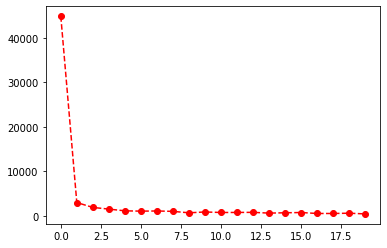

In [39]:
plt.plot(lloss[:20], 'ro--')

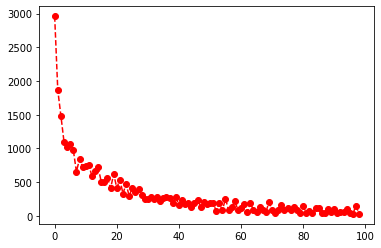

In [40]:
plt.plot(lloss[1:100], "ro--")

## テスト

In [41]:
ldiff = []
num_test = 100
X_test, y_test = generate_data(num_test)

for i in range(num_test):
    y_pred, _ = model(X_test[i].unsqueeze(0))
    diff = np.abs(X_test[i].sum().data.item() - y_pred.data.item())
    ldiff.append(diff)
ldiff = np.array(ldiff)
print(ldiff.sum())

367.7651436328888


# 画像でLSTM
[参考](https://note.com/okonomiyaki011/n/nc79ce0563b0d)

In [1]:
import numpy as np
from keras.utils import np_utils
from keras.datasets import fashion_mnist

In [2]:
# !pip install tensorflow

## データの前処理

**画像を時系列データとして扱うとは？**

ポイント
* イメージとして画像を上からスキャンしていくような感じ。これにより、各行28ピクセルの時系列データとして、時間が進むにつれ、下に1ピクセルづつ降りていくような感じ。これにより28x28で構成された画像を時系列データとして扱うことができる。

* なお「Keras」では、今回使用するデータセットを読み込みと(画像の数, 画像の行, 画像の列)の3次元配列として読み込まれるので、入力層の形状を下のよに定義すれば、1枚の画像につき、28時刻の時系列データとして読み込ませることができる。↓

`model.add(InputLayer(input_shape=(28, 28)))`

In [3]:
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

# 時系列データとして扱えるようにする
x_train = np.reshape(x_train, (-1, 28, 28))
x_train = x_train.astype('float32')
x_train = x_train / 255

# 正解ラベル
correct = 10
y_train = np_utils.to_categorical(y_train, correct)


# 時系列データとして扱えるようにする
x_test = np.reshape(x_test, (-1, 28, 28))
x_test = x_test.astype('float32')
x_test = x_test / 255
y_test = np_utils.to_categorical(y_test, correct)

(60000, 28, 28)
(60000, 28, 28)
(60000, 28, 28)
(60000, 28, 28)


* LSTMでは128のLSTMセルを配置し、これを3段に重ねた3層構造にしている。なお各ブロックでのドロップアウト率は0.25としている。「return_sequences」はLSTMの出力を階層でやり取りするかどうかを指定するための引数。

In [4]:
# 使用するモジュールのインポート
from keras.models import Sequential
from keras.layers import InputLayer, Dense
from keras.layers.recurrent import LSTM
from keras import optimizers,regularizers

# Sequentialオブジェクトを生成
model = Sequential()

model.add(
   InputLayer(input_shape=(28,28))#入口の設定
   )


weight_decay = 1e-4
model.add(LSTM(units=128, dropout=0.25, return_sequences=True))
model.add(LSTM(units=128, dropout=0.25, return_sequences=True))
model.add(LSTM(units=128, dropout=0.25, return_sequences=False,
              kernel_regularizer=regularizers.l2(weight_decay))
)

model.add(
   Dense(units=10,
         activation='softmax')
   )


model.compile(
   loss='categorical_crossentropy',
   optimizer=optimizers.Adam(),    
   metrics=['accuracy']            
   )

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 28, 128)           80384     
_________________________________________________________________
lstm_1 (LSTM)                (None, 28, 128)           131584    
_________________________________________________________________
lstm_2 (LSTM)                (None, 128)               131584    
_________________________________________________________________
dense (Dense)                (None, 10)                1290      
Total params: 344,842
Trainable params: 344,842
Non-trainable params: 0
_________________________________________________________________


In [7]:
history = model.fit(x_train, y_train, 
                   batch_size=100, epochs=50,
                   verbose=1,          
                   validation_data=(   
                   x_test, y_test))

Epoch 1/50
600/600 [==============================] - 36s 60ms/step - loss: 0.6874 - accuracy: 0.7473 - val_loss: 0.5105 - val_accuracy: 0.8157
Epoch 2/50
600/600 [==============================] - 36s 60ms/step - loss: 0.4841 - accuracy: 0.8225 - val_loss: 0.4503 - val_accuracy: 0.8404
Epoch 3/50
600/600 [==============================] - 36s 60ms/step - loss: 0.4271 - accuracy: 0.8435 - val_loss: 0.3971 - val_accuracy: 0.8567
Epoch 4/50
600/600 [==============================] - 37s 61ms/step - loss: 0.3986 - accuracy: 0.8540 - val_loss: 0.3885 - val_accuracy: 0.8582
Epoch 5/50
600/600 [==============================] - 36s 61ms/step - loss: 0.3786 - accuracy: 0.8615 - val_loss: 0.3734 - val_accuracy: 0.8643
Epoch 6/50
600/600 [==============================] - 36s 61ms/step - loss: 0.3609 - accuracy: 0.8676 - val_loss: 0.3524 - val_accuracy: 0.8698
Epoch 7/50
600/600 [==============================] - 36s 61ms/step - loss: 0.3474 - accuracy: 0.8728 - val_loss: 0.3626 - val_accuracy:

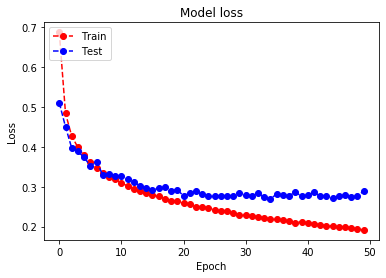

In [15]:
import matplotlib.pyplot as plt

# Plot training & validation loss values
plt.plot(history.history['loss'], "ro--")
plt.plot(history.history['val_loss'], "bo--")
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()